# Gromacs XTC files analysis

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

In [2]:
%load_ext watermark
%watermark --python --machine
# Python packages versions
%watermark --packages jupyterlab --iversions --watermark
# conda environment name
%watermark --conda

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.6.0

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.0-67-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

jupyterlab: 3.6.1

numpy     : 1.24.2
pandas    : 1.5.3
matplotlib: 3.5.3

Watermark: 2.3.1

conda environment: mdda



In [3]:
pd.set_option("display.max_colwidth", None)

## Load data

The last line of `gmxcheck_results.csv` contains `number of not complete xtc files :  1523` that needs to be ignored.

In [4]:
xtc_df = pd.read_csv("../data/gmxcheck_results.csv", skipfooter=1, engine="python")
print(xtc_df.shape)
xtc_df.head()

(1894, 7)


,nbatoms,nbframes,timestep,sim_time,database,ID,path
0,3468.0,226.0,20000.0,NaN,osf,6fuqs,/data/project/mdws.git/data/downloads/osf/6fuqs/Trajectories/4_7byl.xtc\n
1,51523.0,2001.0,100.0,200000.0,osf,8tbp2,/data/project/mdws.git/data/downloads/osf/8tbp2/traj98.xtc\n
2,20324.0,5023.0,100.0,NaN,osf,wytg2,/data/project/mdws.git/data/downloads/osf/wytg2/amber_SH_dimer/traj_mol_ur_nojump_PROT.xtc\n
3,319600.0,2001.0,500.0,1000000.0,osf,u8xrn,/data/project/mdws.git/data/downloads/osf/u8xrn/traj_all.xtc\n
4,2410.0,8000.0,1.0,NaN,osf,7jqyz,/data/project/mdws.git/data/downloads/osf/7jqyz/Markov_model/center_structures_15dists_8kcenters.xtc\n


## Create an extra column with dataset origin and ID

In [5]:
def create_dataset_name(row):
    return f"{row['database']}_{row['ID']}"

xtc_df["dataset"] = xtc_df.apply(create_dataset_name, axis="columns")
xtc_df.head()

,nbatoms,nbframes,timestep,sim_time,database,ID,path,dataset
0,3468.0,226.0,20000.0,NaN,osf,6fuqs,/data/project/mdws.git/data/downloads/osf/6fuqs/Trajectories/4_7byl.xtc\n,osf_6fuqs
1,51523.0,2001.0,100.0,200000.0,osf,8tbp2,/data/project/mdws.git/data/downloads/osf/8tbp2/traj98.xtc\n,osf_8tbp2
2,20324.0,5023.0,100.0,NaN,osf,wytg2,/data/project/mdws.git/data/downloads/osf/wytg2/amber_SH_dimer/traj_mol_ur_nojump_PROT.xtc\n,osf_wytg2
3,319600.0,2001.0,500.0,1000000.0,osf,u8xrn,/data/project/mdws.git/data/downloads/osf/u8xrn/traj_all.xtc\n,osf_u8xrn
4,2410.0,8000.0,1.0,NaN,osf,7jqyz,/data/project/mdws.git/data/downloads/osf/7jqyz/Markov_model/center_structures_15dists_8kcenters.xtc\n,osf_7jqyz


## Remove unwanted rows

Remove:
- missing values,
- redundant datasets,
- space in paths (that leads to Nan).

In [6]:
xtc_df = (xtc_df
 .dropna(subset=["nbatoms", "nbframes"])
 .drop_duplicates(subset="dataset", keep="first")
 .query("path.str.contains(' ') == False")
)         
print(xtc_df.shape)

(779, 8)


Remove `\n` at the end of path

In [7]:
xtc_df["path"] = xtc_df["path"].str[:-1]

Remove prefix `/data/project/mdws.git/data/downloads/`

In [8]:
xtc_df["path"] = xtc_df["path"].str.replace("/data/project/mdws.git/data/downloads/", "")

/tmp/ipykernel_268106/3253067677.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  xtc_df["path"] = xtc_df["path"].str.replace("/data/project/mdws.git/data/downloads/", "")


## Plot system size and number of frames distribution

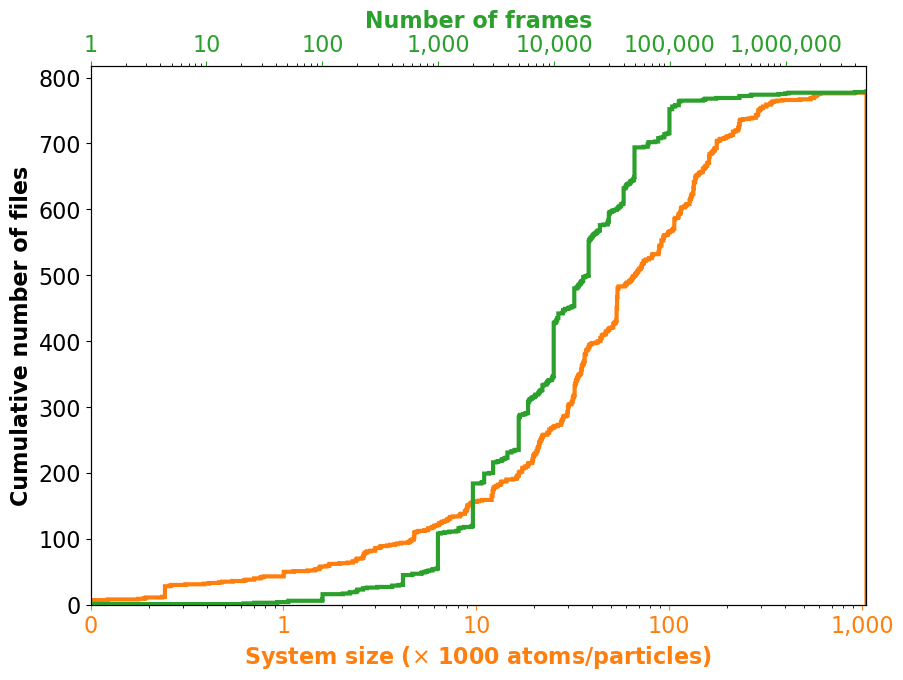

In [9]:
def plot_system_size_frames_distribution(df):
    """Plot system size and frames distribution"""
    bins = 2_000
    plt.rcParams.update({"font.size": 16})
    fig, ax = plt.subplots(figsize=(10,7))
    plt.gca().xaxis.set_major_formatter(mticker.ScalarFormatter())
    plt.ticklabel_format(style='plain')
    
    # Convert system size to k-particles (1000) 
    df["k_particles"] = df["nbatoms"] / 1_000
    logbins = np.geomspace(df["k_particles"].min(), df["k_particles"].max(), bins)
    values, _, _ = ax.hist(
        df["k_particles"], 
        bins=logbins,
        color="tab:orange", linewidth=3,
        histtype="step", cumulative=True
    )
    ax.set_xlabel(r"System size ($\times$ 1000 atoms/particles)", weight="bold")
    ax.set_ylabel("Cumulative number of files", weight="bold")
    ax.set_xscale("log")
    ax.set_xlim(0.1, 0.99*df["k_particles"].max())
    ax.tick_params(axis="x", colors="tab:orange")
    ax.xaxis.label.set_color("tab:orange")
    ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))
    
    logbins = np.geomspace(df["nbframes"].min(), df["nbframes"].max(), bins)
    ax2 = ax.twiny()
    ax2.set_xlabel(r"Number of frames", weight="bold")
    values, _, _ = ax2.hist(
        df["nbframes"], 
        bins=logbins,
        color="tab:green", linewidth=3,
        histtype="step", cumulative=True
    )
    ax2.set_xscale("log")
    ax2.xaxis.label.set_color("tab:green")
    ax2.set_xlim(1, 0.97*df["nbframes"].max())
    ax2.tick_params(axis="x", colors="tab:green")
    ax2.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))


    filename = "fig/gromacs_xtc_system_size_frames_cumulative_distribution"
    plt.savefig(f"{filename}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{filename}.svg", bbox_inches="tight")

plot_system_size_frames_distribution(xtc_df)

## xtc file with largest system size

In [10]:
(xtc_df
 .sort_values(by="nbatoms", ascending=False)
 .head(1)
 .squeeze()
)

nbatoms                                    1055753.0
nbframes                                     10001.0
timestep                                       100.0
sim_time                                   1000000.0
database                                      zenodo
ID                                           3756664
path           zenodo/3756664/micro_40mMNaClskip.xtc
dataset                               zenodo_3756664
k_particles                                 1055.753
Name: 545, dtype: object

Zenodo dataset [3756664](https://zenodo.org/record/3756664). Corresponding .gro file: `confEND.gro`

## xtc file with largest number of frames

In [11]:
(xtc_df
 .sort_values(by="nbframes", ascending=False)
 .head(1)
 .squeeze()
)

nbatoms                         2612.0
nbframes                     5067122.0
timestep                           1.0
sim_time                           NaN
database                        zenodo
ID                             3989044
path           zenodo/3989044/sim1.xtc
dataset                 zenodo_3989044
k_particles                      2.612
Name: 337, dtype: object

Zenodo dataset [3989044](https://zenodo.org/record/3989044). Corresponding .gro (actually .tpr) file: `sim1.tpr`